In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [2]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class GroceryStore:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    grocery_store = GroceryStore(arrival_rate, service_rate)
    grocery_store.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return grocery_store

In [3]:
# Run a short test
grocery_store = run_simulation(arrival_rate=1.2, service_rate=1, run_until=100)
print(f'There are {grocery_store.queue.people_in_queue} people in the queue')

There are 39 people in the queue


1-2.
Running the experiment 100 times with the arrival rate of 0.8, we get the following data.
Sample mean: 1.53
Standard error of the mean: 0.20273633172675337
95% confidence interval of population mean: [1.9273632101844367, 1.1326367898155634]


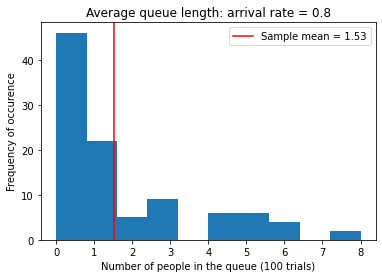

3.
Running the experiment 1000 times with the arrival rate of 0.8, we get the following data.
Sample mean: 1.749
Standard error of the mean: 0.07961367556731279
95% confidence interval of population mean: [1.9050428041119332, 1.592957195888067]


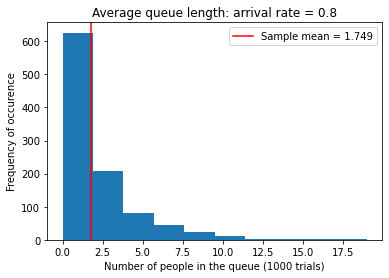

5.a)
Running the experiment 1000 times with the arrival rate of 0.7, we get the following data.
Sample mean: 0.818
Standard error of the mean: 0.04322898038058201
95% confidence interval of population mean: [0.9027288015459407, 0.7332711984540592]


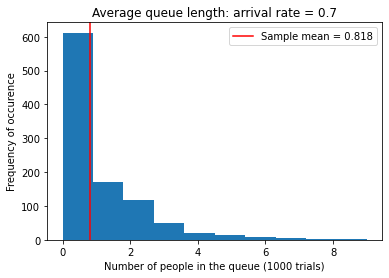

5.b)
Running the experiment 1000 times with the arrival rate of 0.9, we get the following data.
Sample mean: 3.393
Standard error of the mean: 0.11564568701393461
95% confidence interval of population mean: [3.6196655465473118, 3.166334453452688]


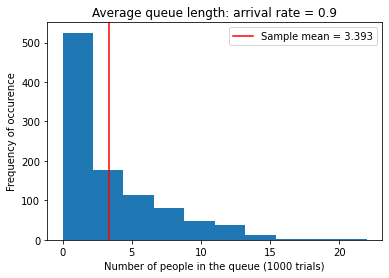

5.c)
Running the experiment 1000 times with the arrival rate of 1, we get the following data.
Sample mean: 7.436
Standard error of the mean: 0.19322328855300866
95% confidence interval of population mean: [7.814717645563897, 7.0572823544361025]


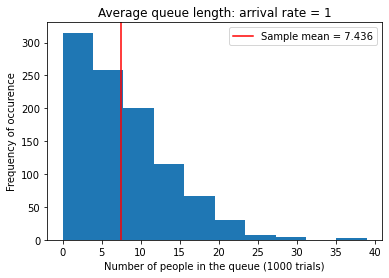

5.d)
Running the experiment 1000 times with the arrival rate of 1.1, we get the following data.
Sample mean: 14.265
Standard error of the mean: 0.26773205907297587
95% confidence interval of population mean: [14.789754835783032, 13.740245164216969]


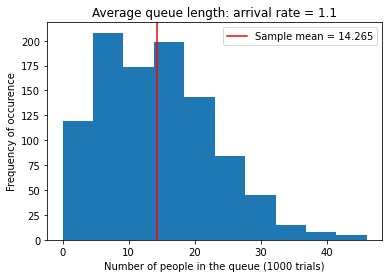

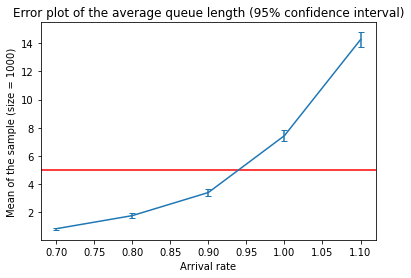

In [56]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt

def experiment(number_of_times, arrival_rate):
    
    sample = []
    
    for i in range(number_of_times):
        grocery_store = run_simulation(arrival_rate=arrival_rate, service_rate=1, run_until=100)
        sample.append(grocery_store.queue.people_in_queue)
    
    print(f'Running the experiment {number_of_times} times with the arrival rate of {arrival_rate}, we get the following data.')
    
    m = np.mean(sample)
    print('Sample mean:', m)
    t = sts.sem(sample)
    print('Standard error of the mean:', t)
    print('95% confidence interval of population mean:', [m + 1.96*t, m - 1.96*t])
    
    plt.hist(sample)
    plt.title(f'Average queue length: arrival rate = {arrival_rate}')
    plt.xlabel(f'Number of people in the queue ({number_of_times} trials)')
    plt.ylabel('Frequency of occurence')
    plt.axvline(m, color = 'red', label = f'Sample mean = {m}')
    plt.legend()
    plt.show()
    
    return m, t

print('1-2.')
experiment(100, 0.8)
print('3.')
m2, t2 = experiment(1000, 0.8)
print('5.a)')
m1, t1 = experiment(1000, 0.7)
print('5.b)')
m3, t3 = experiment(1000, 0.9)
print('5.c)')
m4, t4 = experiment(1000, 1)
print('5.d)')
m5, t5 = experiment(1000, 1.1)

a = [0.7, 0.8, 0.9, 1, 1.1]
m = [m1, m2, m3, m4, m5]
c = [1.96*t1, 1.96*t2, 1.96*t3, 1.96*t4, 1.96*t5]

plt.errorbar(a, m, c, capsize = 3)
plt.title('Error plot of the average queue length (95% confidence interval)')
plt.xlabel('Arrival rate')
plt.ylabel('Mean of the sample (size = 1000)')
plt.axhline(5, color = 'red', label = f'5 people in the queue')
plt.show()

4. As the sample size has increased, the shape of the histogram became more apparent, showing more clearly the exponential distribution. Although the average queue length estimate has not changed much, its confidence interval got smaller, allowing for more precision.
5. The average queue length starts exceeding 5 people when the arrival rate gets higher than 1.

For EmpriricalAnalysis I have produced an visualized the analysis for the problem given correctly and precisely, choosing visualizations appropriately and ensuring they are easy to interpret. I have also run a simulation an adequate number of times to ensure reproducibility of the results.
For Professionalism I have folowed all the provided guidelines and presented the work product in the sophisticated, easily interpretable manner, structuring it logically. All the notations were used correctly, the choice of tools was appropriate. Everything is proofread and completed.